# Exploring and Visualizing OpenAQ Data

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import openaq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
sns.set_theme(style="darkgrid")

from shapely.geometry import Point

import geopandas as gpd
from geopandas import GeoDataFrame

import geoplot as gplt
import geoplot.crs as gcrs

import fiona

import imageio
import os

import viz_utils as vu

ERROR 1: PROJ: proj_create_from_database: Open of /home/jovyan/envs/aqproject/share/proj failed


In [2]:
api = openaq.OpenAQ()
resp = api.cities(df=True, limit=10000)

In [3]:
resp.query('city.str.contains("San") and country.str.contains("US")', engine='python')

country                              name  \
145       US    Atlanta-Sandy Springs-Marietta   
1382      US  Los Angeles-Long Beach-Santa Ana   
2029      US  Riverside-San Bernardino-Ontario   
2095      US                       San Antonio   
2103      US     San Diego-Carlsbad-San Marcos   
2109      US            San Francisco Bay Area   
2110      US     San Francisco-Oakland-Fremont   
2112      US    San Jose-Sunnyvale-Santa Clara   
2115      US          San Juan-Caguas-Guaynabo   
2122      US       San Luis Obispo-Paso Robles   
2127      US         Santa Barbara-Santa Maria   
2130      US            Santa Cruz-Watsonville   
2132      US                          Santa Fe   
2135      US               Santa Rosa-Petaluma   

                                  city    count  locations  
145     Atlanta-Sandy Springs-Marietta  1905801         13  
1382  Los Angeles-Long Beach-Santa Ana  5566695         32  
2029  Riverside-San Bernardino-Ontario  5442507         42  
2095                       San Antonio   514007          8  
2103     San Diego-Carlsbad-San Marcos  1007765         11  
2109            San Francisco Bay Area   152929          1  
2110     San Francisco-Oakland-Fremont  4659301         15  
2112    San Jose-Sunnyvale-Santa Clara  1313604          8  
2115          San Juan-Caguas-Guaynabo     8475          1  
2122       San Luis Obispo-Paso Robles  1614077         34  
2127         Santa Barbara-Santa Maria  2073617         18  
2130            Santa Cruz-Watsonville   257952          8  
2132                          Santa Fe   196646          1  
2135               Santa Rosa-Petaluma   371125          1

In [4]:
res = api.locations(city='San Francisco-Oakland-Fremont', df=True)

<AxesSubplot:>

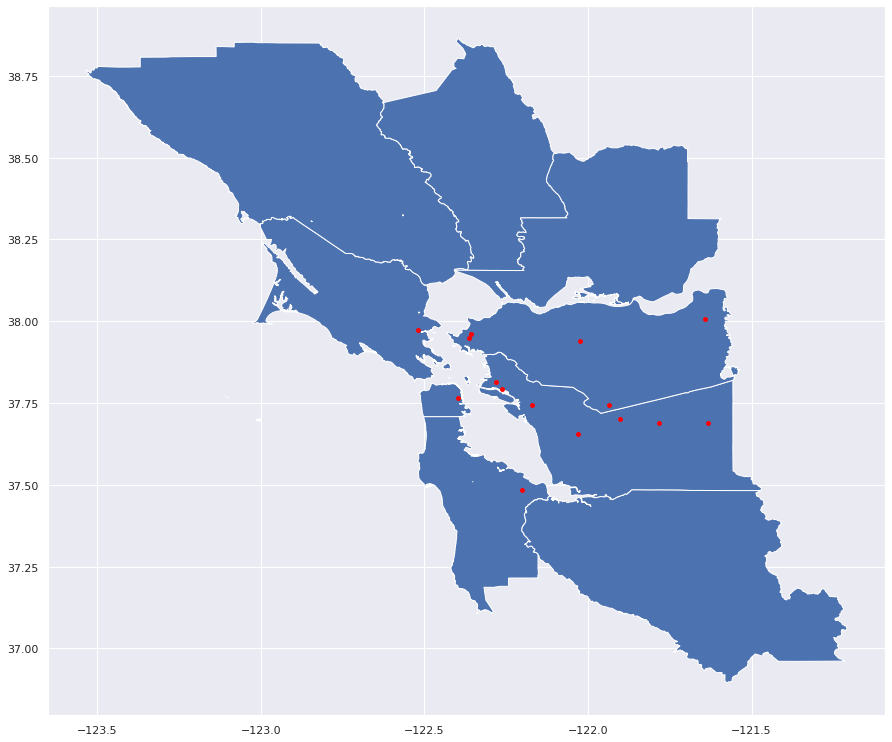

In [5]:
geometry = [Point(xy) for xy in zip(res['coordinates.longitude'], res['coordinates.latitude'])]
gdf = GeoDataFrame(res, geometry=geometry)
world = gpd.read_file("https://data.sfgov.org/api/geospatial/s9wg-vcph?method=export&format=Shapefile")
gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=15)

In [6]:
measure = api.measurements(city='San Francisco-Oakland-Fremont', parameter='pm25', limit=1000, df=True)

# Print out the statistics on a per-location basiss
measure.groupby(['location'])['value'].describe()

count      mean       std  min  25%  50%   75%   max
location                                                                  
Concord               102.0  4.764706  2.247888 -1.0  3.0  5.0   6.0   9.0
Laney College          87.0  5.195402  2.361706  0.0  4.0  5.0   7.0  10.0
Livermore - Rincon     90.0  4.711111  2.399646 -1.0  3.0  4.0   6.0  12.0
Oakland               103.0  5.310680  1.980439  1.0  4.0  5.0   7.0  11.0
Oakland West          104.0  4.394231  2.447183 -1.0  3.0  4.0   6.0  11.0
Pleasanton - Owens C  102.0  5.137255  2.540910 -1.0  3.0  5.0   6.0  13.0
Redwood City          103.0  3.223301  2.866069 -3.0  1.0  4.0   5.0  10.0
San Francisco         104.0  4.653846  3.299806 -1.0  2.0  5.0   7.0  17.0
San Pablo - Rumrill   100.0  9.440000  8.404328  0.0  5.0  7.0  10.0  43.0
San Rafael            105.0  4.638095  2.609612 -2.0  3.0  5.0   6.0  12.0

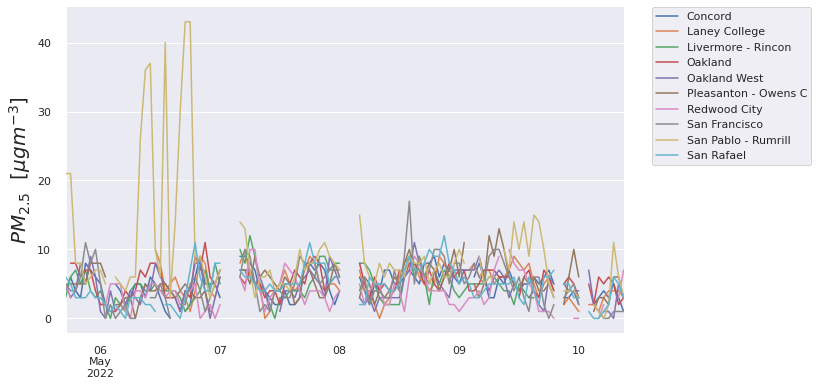

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 6))

for group, df in measure.groupby('location'):
    # Query the data to only get positive values and resample to hourly
    _df = df.query("value >= 0.0").resample('1h').mean()

    _df.value.plot(ax=ax, label=group)

ax.legend(loc='best')
ax.set_ylabel("$PM_{2.5}$  [$\mu g m^{-3}$]", fontsize=20)
ax.set_xlabel("")
sns.despine(offset=5)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

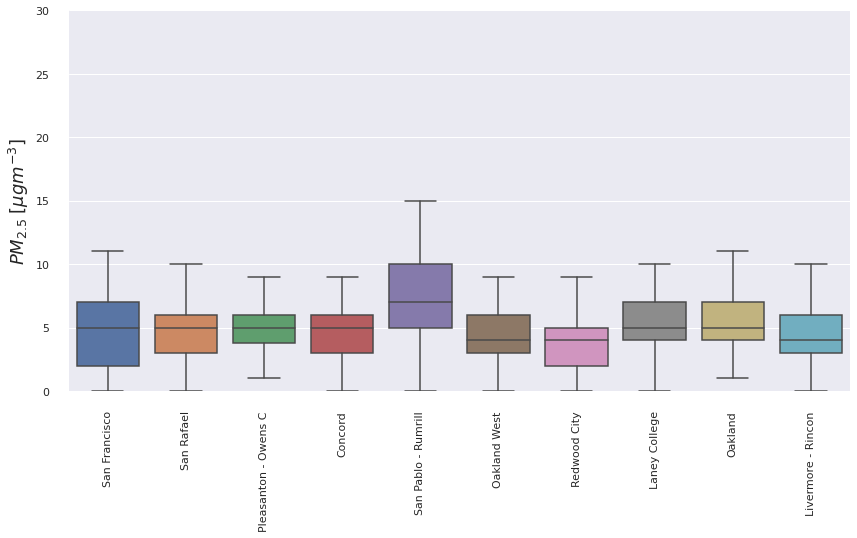

In [8]:
fig, ax = plt.subplots(1, figsize=(14,7))

ax = sns.boxplot(
    x='location',
    y='value',
    data=measure.query("value >= 0.0"),
    fliersize=0,
    palette='deep',
    ax=ax)

ax.set_ylim([0, 30])
ax.set_ylabel("$PM_{2.5}\;[\mu gm^{-3}]$", fontsize=18)
ax.set_xlabel("")

sns.despine(offset=10)

plt.xticks(rotation=90)
plt.show()

In [9]:
sanfrancisco = api.locations(city='San Francisco-Oakland-Fremont', df=True)


sanfrancisco.iloc[0]


id                                                                    1311
country                                                                 US
city                                         San Francisco-Oakland-Fremont
cities                                     [San Francisco-Oakland-Fremont]
location                                                     Laney College
locations                                                  [Laney College]
sourceName                                                          AirNow
sourceNames                                                       [AirNow]
sourceType                                                      government
sourceTypes                                                   [government]
firstUpdated                                     2016-03-06 19:00:00+00:00
lastUpdated                                      2022-05-10 16:00:00+00:00
parameters                                             [no2, bc, pm25, co]
countsByMeasurement      

In [10]:
dark_day_sf_pm25 = api.measurements(location='San Francisco', parameter='pm25', date_from='2020-09-07', date_to='2020-09-13', df=True, limit=1000)
dark_day_sf_pm25.head()

location parameter  value                    unit  \
date.local                                                                    
2020-09-12 17:00:00  San Francisco      pm25     77  b'\xc2\xb5g/m\xc2\xb3'   
2020-09-12 16:00:00  San Francisco      pm25     78  b'\xc2\xb5g/m\xc2\xb3'   
2020-09-12 15:00:00  San Francisco      pm25     77  b'\xc2\xb5g/m\xc2\xb3'   
2020-09-12 14:00:00  San Francisco      pm25     83  b'\xc2\xb5g/m\xc2\xb3'   
2020-09-12 13:00:00  San Francisco      pm25     87  b'\xc2\xb5g/m\xc2\xb3'   

                    country                           city  \
date.local                                                   
2020-09-12 17:00:00      US  San Francisco-Oakland-Fremont   
2020-09-12 16:00:00      US  San Francisco-Oakland-Fremont   
2020-09-12 15:00:00      US  San Francisco-Oakland-Fremont   
2020-09-12 14:00:00      US  San Francisco-Oakland-Fremont   
2020-09-12 13:00:00      US  San Francisco-Oakland-Fremont   

                                     date.utc  coordinates.latitude  \
date.local                                                            
2020-09-12 17:00:00 2020-09-13 00:00:00+00:00               37.7658   
2020-09-12 16:00:00 2020-09-12 23:00:00+00:00               37.7658   
2020-09-12 15:00:00 2020-09-12 22:00:00+00:00               37.7658   
2020-09-12 14:00:00 2020-09-12 21:00:00+00:00               37.7658   
2020-09-12 13:00:00 2020-09-12 20:00:00+00:00               37.7658   

                     coordinates.longitude  
date.local                                  
2020-09-12 17:00:00              -122.3978  
2020-09-12 16:00:00              -122.3978  
2020-09-12 15:00:00              -122.3978  
2020-09-12 14:00:00              -122.3978  
2020-09-12 13:00:00              -122.3978

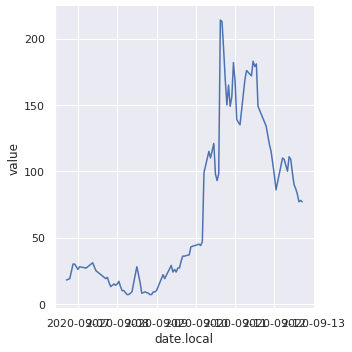

In [11]:
g = sns.relplot(x=dark_day_sf_pm25.index, y='value', kind='line', data=dark_day_sf_pm25)
#g.set(xticks=range(len(dark_day_sf_pm25.index)+1))

In [12]:
dark_max = dark_day_sf_pm25[dark_day_sf_pm25.value == dark_day_sf_pm25.value.max()]
dark_max

location parameter  value                    unit  \
date.local                                                                    
2020-09-10 15:00:00  San Francisco      pm25    214  b'\xc2\xb5g/m\xc2\xb3'   

                    country                           city  \
date.local                                                   
2020-09-10 15:00:00      US  San Francisco-Oakland-Fremont   

                                     date.utc  coordinates.latitude  \
date.local                                                            
2020-09-10 15:00:00 2020-09-10 22:00:00+00:00               37.7658   

                     coordinates.longitude  
date.local                                  
2020-09-10 15:00:00              -122.3978

In [13]:
test = api.measurements(city='San Francisco-Oakland-Fremont', date_from='2020-09-07', date_to='2020-09-08', df=True, limit=1000)
test = test[test['parameter'] == 'pm25']
test = test[test['date.utc'] == '2020-09-07 13:00:00+00:00']
test

location parameter  value  \
date.local                                                   
2020-09-07 06:00:00               Concord      pm25   21.0   
2020-09-07 06:00:00         Laney College      pm25   21.0   
2020-09-07 06:00:00    Livermore - Rincon      pm25   30.0   
2020-09-07 06:00:00          Redwood City      pm25   30.0   
2020-09-07 06:00:00          Oakland West      pm25   21.0   
2020-09-07 06:00:00            San Rafael      pm25   18.0   
2020-09-07 06:00:00               Oakland      pm25   21.0   
2020-09-07 06:00:00  Pleasanton - Owens C      pm25   32.0   
2020-09-07 06:00:00   San Pablo - Rumrill      pm25   16.0   
2020-09-07 06:00:00         San Francisco      pm25   28.0   

                                       unit country  \
date.local                                            
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   

                                              city                  date.utc  \
date.local                                                                     
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   

                     coordinates.latitude  coordinates.longitude  
date.local                                                        
2020-09-07 06:00:00             37.938300            -122.025000  
2020-09-07 06:00:00             37.793624            -122.263376  
2020-09-07 06:00:00             37.687526            -121.784217  
2020-09-07 06:00:00             37.482800            -122.202200  
2020-09-07 06:00:00             37.814800            -122.282402  
2020-09-07 06:00:00             37.972200            -122.518900  
2020-09-07 06:00:00             37.743061            -122.169907  
2020-09-07 06:00:00             37.701222            -121.903019  
2020-09-07 06:00:00             37.960400            -122.357100  
2020-09-07 06:00:00             37.765800            -122.397800

In [14]:
geometry = [Point(xy) for xy in zip(test['coordinates.longitude'], test['coordinates.latitude'])]
gdf = GeoDataFrame(test, geometry=geometry)

gdf


location parameter  value  \
date.local                                                   
2020-09-07 06:00:00               Concord      pm25   21.0   
2020-09-07 06:00:00         Laney College      pm25   21.0   
2020-09-07 06:00:00    Livermore - Rincon      pm25   30.0   
2020-09-07 06:00:00          Redwood City      pm25   30.0   
2020-09-07 06:00:00          Oakland West      pm25   21.0   
2020-09-07 06:00:00            San Rafael      pm25   18.0   
2020-09-07 06:00:00               Oakland      pm25   21.0   
2020-09-07 06:00:00  Pleasanton - Owens C      pm25   32.0   
2020-09-07 06:00:00   San Pablo - Rumrill      pm25   16.0   
2020-09-07 06:00:00         San Francisco      pm25   28.0   

                                       unit country  \
date.local                                            
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   

                                              city                  date.utc  \
date.local                                                                     
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   

                     coordinates.latitude  coordinates.longitude  \
date.local                                                         
2020-09-07 06:00:00             37.938300            -122.025000   
2020-09-07 06:00:00             37.793624            -122.263376   
2020-09-07 06:00:00             37.687526            -121.784217   
2020-09-07 06:00:00             37.482800            -122.202200   
2020-09-07 06:00:00             37.814800            -122.282402   
2020-09-07 06:00:00             37.972200            -122.518900   
2020-09-07 06:00:00             37.743061            -122.169907   
2020-09-07 06:00:00             37.701222            -121.903019   
2020-09-07 06:00:00             37.960400            -122.357100   
2020-09-07 06:00:00             37.765800            -122.397800   

                                        geometry  
date.local                                        
2020-09-07 06:00:00  POINT (-122.02500 37.93830)  
2020-09-07 06:00:00  POINT (-122.26338 37.79362)  
2020-09-07 06:00:00  POINT (-121.78422 37.68753)  
2020-09-07 06:00:00  POINT (-122.20220 37.48280)  
2020-09-07 06:00:00  POINT (-122.28240 37.81480)  
2020-09-07 06:00:00  POINT (-122.51890 37.97220)  
2020-09-07 06:00:00  POINT (-122.16991 37.74306)  
2020-09-07 06:00:00  POINT (-121.90302 37.70122)  
2020-09-07 06:00:00  POINT (-122.35710 37.96040)  
2020-09-07 06:00:00  POINT (-122.39780 37.76580)

Text(0.5, 1.0, 'Bay Area pm25 on ')

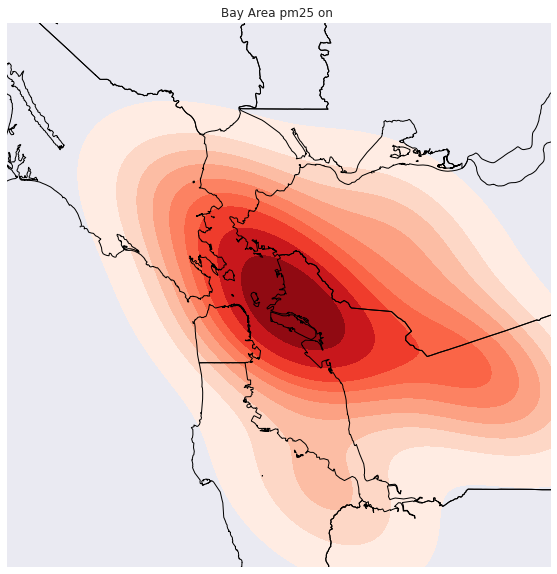

In [15]:
proj = gcrs.AlbersEqualArea(central_latitude=37.8711428, central_longitude=-122.3714777)
fig= plt.figure(figsize=(10, 10))
ax1 = plt.subplot(111, projection=proj)

gplt.kdeplot(
    gdf,
    cmap='Reds',
    projection=proj,
    shade=True, thresh=0.05,
    ax=ax1
)
gplt.polyplot(world, zorder=1, ax=ax1)
ax1.axis(xmin=-50000,xmax=60000, ymin=-60000, ymax=50000)
ax1.set_title("Bay Area pm25 on ")

In [16]:
USlocs = api.locations(country='US', df=True, limit=10000)

USlocs.head()

id country                  city                  cities  \
0  212      US            Fort Smith            [Fort Smith]   
1  213      US            TWIN FALLS            [TWIN FALLS]   
2  215      US               TUSCOLA               [TUSCOLA]   
3  216      US  South Bend-Mishawaka  [South Bend-Mishawaka]   
4  221      US          Indianapolis          [Indianapolis]   

               location                                locations sourceName  \
0                ROLAND                                 [ROLAND]     AirNow   
1       Twin Falls PM25  [Twin Falls 1405 TEOM, Twin Falls PM25]     AirNow   
2            Unionville                             [Unionville]     AirNow   
3  South Bend-Shields D                   [South Bend-Shields D]     AirNow   
4  Indpls-Washington Pa                   [Indpls-Washington Pa]     AirNow   

  sourceNames  sourceType   sourceTypes              firstUpdated  \
0    [AirNow]  government  [government] 2016-03-06 19:00:00+00:00   
1    [AirNow]  government  [government] 2016-03-06 19:00:00+00:00   
2    [AirNow]  government  [government] 2016-03-11 22:00:00+00:00   
3    [AirNow]  government  [government] 2016-03-06 19:00:00+00:00   
4    [AirNow]  government  [government] 2016-03-06 19:00:00+00:00   

                lastUpdated                          parameters  \
0 2022-05-10 16:00:00+00:00               [pm10, pm25, o3, no2]   
1 2022-05-10 16:00:00+00:00                              [pm25]   
2 2022-05-10 16:00:00+00:00                                [o3]   
3 2022-05-10 16:00:00+00:00                     [o3, no2, pm25]   
4 2022-05-10 16:00:00+00:00  [o3, pm25, pm10, bc, no2, co, so2]   

                                 countsByMeasurement   count  \
0  [{'parameter': 'pm10', 'count': 5}, {'paramete...  205051   
1           [{'parameter': 'pm25', 'count': 104090}]  104090   
2              [{'parameter': 'o3', 'count': 80460}]   80460   
3  [{'parameter': 'o3', 'count': 89041}, {'parame...  213058   
4  [{'parameter': 'o3', 'count': 93552}, {'parame...  496281   

   coordinates.latitude  coordinates.longitude  
0             35.408138             -94.524414  
1             42.565089            -114.494717  
2             43.610000             -83.360000  
3             41.696700             -86.214700  
4             39.810800             -86.114700

In [17]:
bay_area_locs = vu.location_filter(USlocs, minlat = 36., minlon = -123.5, maxlat=39., maxlon = -121, starttime='2020-09-07', endtime='2020-09-13') 
bay_area_locs.head()

id country                                 city  \
156  627      US  Sacramento--Arden-Arcade--Roseville   
163  635      US                    Vallejo-Fairfield   
179  655      US  Sacramento--Arden-Arcade--Roseville   
190  671      US                    Vallejo-Fairfield   
224  793      US                             Stockton   

                                    cities   location    locations sourceName  \
156  [Sacramento--Arden-Arcade--Roseville]   Woodland   [Woodland]     AirNow   
163                    [Vallejo-Fairfield]  Vacaville  [Vacaville]     AirNow   
179  [Sacramento--Arden-Arcade--Roseville]     Auburn     [Auburn]     AirNow   
190                    [Vallejo-Fairfield]  Rio Vista  [Rio Vista]     AirNow   
224                             [Stockton]    TracyAP    [TracyAP]     AirNow   

    sourceNames  sourceType   sourceTypes              firstUpdated  \
156    [AirNow]  government  [government] 2016-03-11 15:00:00+00:00   
163    [AirNow]  government  [government] 2016-03-11 15:00:00+00:00   
179    [AirNow]  government  [government] 2016-03-11 15:00:00+00:00   
190    [AirNow]  government  [government] 2016-03-11 15:00:00+00:00   
224    [AirNow]  government  [government] 2016-03-10 07:00:00+00:00   

                  lastUpdated             parameters  \
156 2022-05-10 16:00:00+00:00             [pm25, o3]   
163 2022-05-10 16:00:00+00:00             [pm25, o3]   
179 2022-05-10 16:00:00+00:00             [pm25, o3]   
190 2022-05-10 16:00:00+00:00                 [pm25]   
224 2022-05-10 16:00:00+00:00  [no2, o3, pm10, pm25]   

                                   countsByMeasurement   count  \
156  [{'parameter': 'pm25', 'count': 87305}, {'para...  172063   
163  [{'parameter': 'pm25', 'count': 86910}, {'para...  172261   
179  [{'parameter': 'pm25', 'count': 84850}, {'para...  168711   
190            [{'parameter': 'pm25', 'count': 47143}]   47143   
224  [{'parameter': 'no2', 'count': 64847}, {'param...  310737   

     coordinates.latitude  coordinates.longitude  
156             38.661239            -121.732683  
163             38.356556            -121.949853  
179             38.935680            -121.099590  
190             38.167297            -121.688561  
224             37.682500            -121.440600

In [18]:
df = vu.param_data_per_loc_for_period(bay_area_locs, start_date= '2020-09-07', end_date='2020-09-13', param='pm25', limit=1000, interpolate=True)

In [19]:
df.head()

Woodland  Vacaville  Auburn  Rio Vista    TracyAP  \
2020-09-06 17:00:00      56.0       68.0    12.0       49.0  61.000000   
2020-09-06 19:00:00      63.0       64.0    12.0       51.0  56.333333   
2020-09-06 20:00:00      64.0       70.0    11.5       52.5  51.666667   
2020-09-06 21:00:00      65.0       76.0    11.0       54.0  47.000000   
2020-09-06 22:00:00      63.0       77.0    10.0       32.0  47.333333   

                     Davis - UCD Campus  Gilory - 9th Street  \
2020-09-06 17:00:00                67.4                 34.0   
2020-09-06 19:00:00                68.6                 66.0   
2020-09-06 20:00:00                68.0                 57.5   
2020-09-06 21:00:00                67.4                 49.0   
2020-09-06 22:00:00                71.1                 52.0   

                     Arden Arcade - Del P  Laney College  Livermore - Rincon  \
2020-09-06 17:00:00             27.000000           37.0                71.0   
2020-09-06 19:00:00             26.666667           29.0                62.0   
2020-09-06 20:00:00             26.333333           26.0                59.0   
2020-09-06 21:00:00             26.000000           23.0                56.0   
2020-09-06 22:00:00             39.000000           20.0                41.0   

                     ...  Berkeley Aquatic Par  Napa - Napa Valley C  \
2020-09-06 17:00:00  ...                  27.0                  31.0   
2020-09-06 19:00:00  ...                  22.0                  19.0   
2020-09-06 20:00:00  ...                  23.5                  19.0   
2020-09-06 21:00:00  ...                  25.0                  19.0   
2020-09-06 22:00:00  ...                  22.0                  27.0   

                     MBARD Office - Monte  Watsonville  Big Sur Ranger Stati  \
2020-09-06 17:00:00                  26.0         42.0                  19.0   
2020-09-06 19:00:00                   0.0         42.0                  24.0   
2020-09-06 20:00:00                   9.0         42.0                  23.5   
2020-09-06 21:00:00                  18.0         42.0                  23.0   
2020-09-06 22:00:00                  28.0         42.0                  21.0   

                     Soledad  Greenfield  Gonzales  Soledad_259103  \
2020-09-06 17:00:00     29.0        15.0      36.0            29.0   
2020-09-06 19:00:00     55.0        50.0      39.0            55.0   
2020-09-06 20:00:00     49.0        10.0      41.0            49.0   
2020-09-06 21:00:00     43.0        44.0      43.0            43.0   
2020-09-06 22:00:00     48.0        46.0      43.0            48.0   

                     Gonzales_462099  
2020-09-06 17:00:00             36.0  
2020-09-06 19:00:00             39.0  
2020-09-06 20:00:00             41.0  
2020-09-06 21:00:00             43.0  
2020-09-06 22:00:00             43.0  

[5 rows x 46 columns]

In [20]:
df.size

6348

In [21]:
cities_coordinates, coord_list = vu.cities_coords(bay_area_locs, df)
cities_coordinates.head()

0                     geometry
0   Woodland  POINT (-121.73268 38.66124)
1  Vacaville  POINT (-121.94985 38.35656)
2     Auburn  POINT (-121.09959 38.93568)
3  Rio Vista  POINT (-121.68856 38.16730)
5    TracyAP  POINT (-121.44060 37.68250)

In [22]:
bay_area_dark_days_data = vu.merge_and_save_gdf(cities_coords=cities_coordinates, data=df, save=True, filename='data/bayareadarkdays.geojson')
bay_area_dark_days_data.head()

geometry  2020-09-06 17:00:00  \
Woodland   POINT (-121.73268 38.66124)                 56.0   
Vacaville  POINT (-121.94985 38.35656)                 68.0   
Auburn     POINT (-121.09959 38.93568)                 12.0   
Rio Vista  POINT (-121.68856 38.16730)                 49.0   
TracyAP    POINT (-121.44060 37.68250)                 61.0   

           2020-09-06 19:00:00  2020-09-06 20:00:00  2020-09-06 21:00:00  \
Woodland             63.000000            64.000000                 65.0   
Vacaville            64.000000            70.000000                 76.0   
Auburn               12.000000            11.500000                 11.0   
Rio Vista            51.000000            52.500000                 54.0   
TracyAP              56.333333            51.666667                 47.0   

           2020-09-06 22:00:00  2020-09-07 00:00:00  2020-09-07 01:00:00  \
Woodland             63.000000            60.000000                 48.0   
Vacaville            77.000000            68.000000                 57.0   
Auburn               10.000000             4.000000                  4.0   
Rio Vista            32.000000            19.000000                 18.0   
TracyAP              47.333333            47.666667                 48.0   

           2020-09-07 02:00:00  2020-09-07 03:00:00  ...  2020-09-12 11:00:00  \
Woodland                  42.5                 37.0  ...           220.000000   
Vacaville                 53.0                 49.0  ...           157.000000   
Auburn                     4.0                  4.0  ...            67.000000   
Rio Vista                 20.0                 22.0  ...           127.000000   
TracyAP                   38.5                 29.0  ...           100.666667   

           2020-09-12 12:00:00  2020-09-12 13:00:00  2020-09-12 14:00:00  \
Woodland            192.000000                174.0                134.0   
Vacaville           213.000000                172.0                113.0   
Auburn              102.000000                173.0                224.0   
Rio Vista           125.000000                148.0                183.0   
TracyAP              99.333333                 98.0                109.0   

           2020-09-12 15:00:00  2020-09-12 16:00:00  2020-09-12 17:00:00  \
Woodland                  94.0                 89.0                108.0   
Vacaville                 95.0                 69.0                 84.0   
Auburn                   239.0                189.0                151.0   
Rio Vista                138.0                134.0                103.0   
TracyAP                  108.0                135.5                163.0   

           2020-09-12 18:00:00  2020-09-12 19:00:00  2020-09-12 20:00:00  
Woodland                 108.0                108.0                108.0  
Vacaville                 84.0                 84.0                 84.0  
Auburn                   151.0                151.0                151.0  
Rio Vista                103.0                103.0                103.0  
TracyAP                  163.0                163.0                163.0  

[5 rows x 139 columns]

In [23]:
bay_data = gpd.read_file('data/bayareadarkdays.geojson')

In [24]:
col_list = bay_data.columns
dark_day_cols = [col for col in bay_data.columns if '2020-09-09' in col]
dark_max = [col for col in bay_data.columns if '2020-09-10 15:00:00' in col]

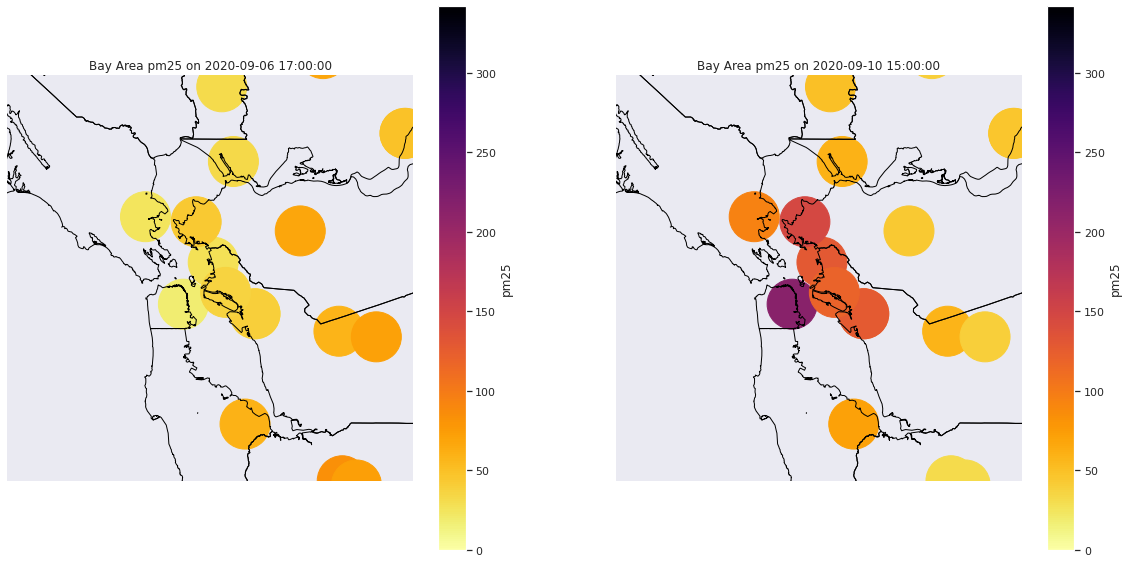

In [25]:
compare = vu.pointmap_compare(loc_name='Bay Area', param='pm25',data = bay_data, date1=col_list[1], date2=dark_max[0], basemap=world, center_lat=37.8711428, center_lon=-122.3714777,
                 color_min=0, color_max=342, xmin=-50000,xmax=60000, ymin=-60000, ymax=50000, min_scale=50, max_scale=50, save=True)

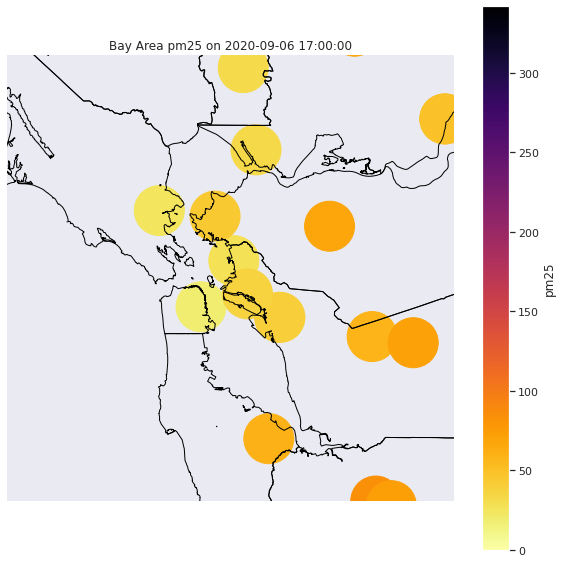

In [26]:
single = vu.pointmap_single(loc_name='Bay Area', param='pm25',data = bay_data, date1=col_list[1], basemap=world, center_lat=37.8711428, center_lon=-122.3714777,
                 color_min=0, color_max=342, xmin=-50000,xmax=60000, ymin=-60000, ymax=50000, min_scale=50, max_scale=50, save=True)

<Figure size 432x288 with 0 Axes>

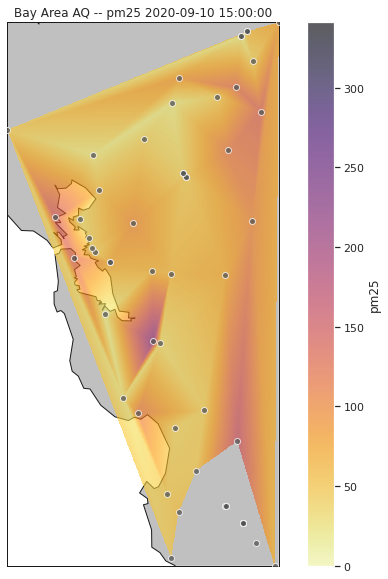

In [27]:
vu.aqviz(bay_data, coord_list, dark_max[0], 'pm25', save=True)

In [29]:
# Keeping this out of a function because it crashes the kernel often

filenames = []
for i in range(1,len(col_list)-1):
    # plot the line chart
    # vu.aqviz(dataframe=bay_data, coords=coord_list, date=col_list[i], param='pm25', save=False)
    
    # create file name and append it to a list
    filename = f'figures/animation_frames/frame_{i}.png'
    filenames.append(filename)
    
    # save frame
    # plt.savefig(filename)
    # plt.close()
    
with imageio.get_writer('figures/timelapsegif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
for filename in set(filenames):
    os.remove(filename)

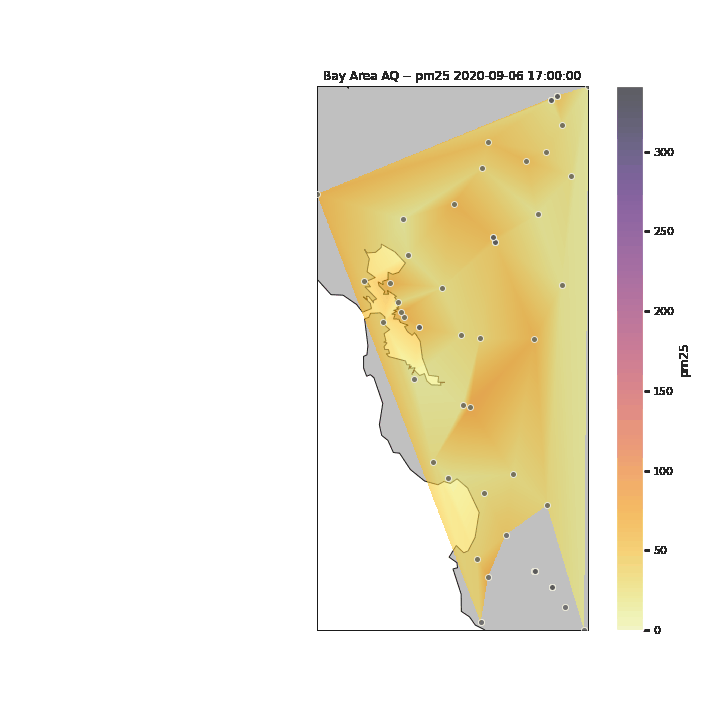

In [30]:
import IPython
path_to_gif = "figures/timelapsegif.gif"
from IPython.core.display import Image
Image(filename=path_to_gif)
